In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
pd.set_option('display.max_rows', 8)
%matplotlib inline
!date

Thu Feb  1 15:42:03 PST 2018


# Modeling SIR infections in Vivarium

In [2]:
import vivarium, vivarium.test_util as vtu

np.random.seed(12345)  # set random seed for reproducibility

n_simulants = 300
n_days = 1000
t_timestep = 1 # days
t_start = pd.Timestamp('1990-01-01')

# Model One: doing it all by hand

In [3]:
from vivarium.framework.event import listens_for

class SI1:
    def setup(self, builder):
        self.population_view = builder.population_view(['disease_state'])
        self.beta = 1.1
        
    @listens_for('initialize_simulants')
    def on_initalize_simulants(self, event):
        """Start most simulants in susceptible state, but one in infected
        """
        disease_state = pd.Series('S', index=event.index,
                                  name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)
        
    @listens_for('time_step')
    def on_time_step(self, event):
        """one step of infectious disease dynamics"""
        pop = self.population_view.get(event.index)
        infected_proportion = np.mean(pop.disease_state == 'I')
        
        rows = (np.random.uniform(size=len(event.index)) < self.beta * infected_proportion)
        pop.disease_state[rows] = 'I'
        self.population_view.update(pop)
        
sim = vtu.setup_simulation([SI1()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=4)

VBox(children=(HTML(value=''), IntProgress(value=0, max=4)))

4

In [4]:
sim.population.population.disease_state.value_counts()

S    275
I     25
Name: disease_state, dtype: int64

In [5]:
# take a look at this, but how
class SIObserver:
    def __init__(self):
        """initialize some dictionaries to hold observations
        """
        self.S = {}
        self.I = {}
        
    def setup(self, builder):
        """get a population view in setup instead of in __init__,
        because it comes from the simulation's builder object
        """
        self.population_view = builder.population_view(['disease_state'])
        
    @listens_for('collect_metrics')
    def on_collect_metrics(self, event):
        """after every time step the simulation engine sends 
        a collect_metrics event, which is the perfect time
        to record some statistics about the state of the simulation
        """
        
        pop = self.population_view.get(event.index)
        self.S[event.time] = np.sum(pop.disease_state == 'S')
        self.I[event.time] = np.sum(pop.disease_state == 'I')

    def show(self):
        """simple plot of observations
        """
        pd.DataFrame([self.S, self.I]).T.plot(marker='s')
        
o = SIObserver()
sim = vtu.setup_simulation([SI1(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=15)

VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

15

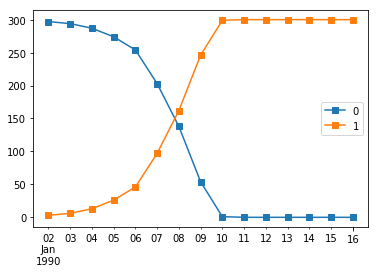

In [6]:
o.show()

# Model Two: use `vivarium` randomness
Better than using `np.random` directly.

VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

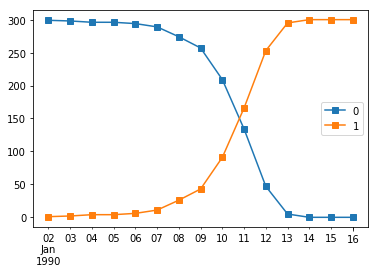

In [7]:
from vivarium.framework.event import listens_for
from vivarium.framework.values import produces_value

class SI2:
    def setup(self, builder):
        """new this time: use builder.randomness to create a random number stream
        """
        self.population_view = builder.population_view(['disease_state'])
        self.beta = 1.1

        self.randomness = builder.randomness('infection')
    
    @listens_for('initialize_simulants')
    def on_initalize_simulants(self, event):
        """Start most simulants in susceptible state, but one in infected
        """
        disease_state = pd.Series('S', index=event.index, name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)
    
    @listens_for('time_step')
    def on_time_step(self, event):
        """one step of infectious disease dynamics, now implemented with
        randomness method provided by vivarium"""
        pop = self.population_view.get(event.index)
        infected_proportion = np.mean(pop.disease_state == 'I')

        infected = self.randomness.filter_for_probability(pop, self.beta * infected_proportion)
        infected = infected.copy()  # HACK: makes a SettingWithCopyWarning go away
        infected.disease_state = 'I'
        self.population_view.update(infected)
        
o = SIObserver()
sim = vtu.setup_simulation([SI2(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=15)
o.show()

In [8]:
# now the randomness is replicable, you don't need to set the random seed anymore
sim = vtu.setup_simulation([SI2()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=10)

sim.population.population.disease_state.value_counts()

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

I    166
S    134
Name: disease_state, dtype: int64

In [9]:
# do it again, get exactly same results

sim = vtu.setup_simulation([SI2()], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=10)

sim.population.population.disease_state.value_counts()

VBox(children=(HTML(value=''), IntProgress(value=0, max=10)))

I    166
S    134
Name: disease_state, dtype: int64

# Model Three: use randomness and pipelines

VBox(children=(HTML(value=''), IntProgress(value=0, max=15)))

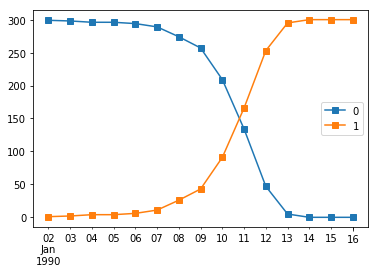

In [10]:
from vivarium.framework.event import listens_for
from vivarium.framework.values import produces_value

class SI3:
    def setup(self, builder):
        self.population_view = builder.population_view(['disease_state'])
        self.beta = 1.1

        self.randomness = builder.randomness('infection')
        self.infection_prob = builder.value('infection_prob')
    
    @listens_for('initialize_simulants')
    def on_initalize_simulants(self, event):
        """Start most simulants in susceptible state, but one in infected
        """
        disease_state = pd.Series('S', index=event.index, name='disease_state')
        disease_state[0] = 'I'
        
        self.population_view.update(disease_state)
    
    @listens_for('time_step__prepare')
    def on_time_step__prepare(self, event):
        """ count number infected
        """
        pop = self.population_view.get(event.index)
        self.infected_proportion = np.mean(pop.disease_state == 'I')
    
    @produces_value('infection_prob')
    def infection_prob_func(self, index):
        return pd.Series(self.beta * self.infected_proportion, index=index)
    
    @listens_for('time_step')
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        infected = self.randomness.filter_for_probability(pop, self.infection_prob(event.index))
        infected = infected.copy()  # makes a SettingWithCopyWarning go away
        infected.disease_state = 'I'
        self.population_view.update(infected)
        
o = SIObserver()
sim = vtu.setup_simulation([SI3(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=15)
o.show()

Seems like more work for no gain... What is the point of the pipeline?  Modularity and composability.

Introduce a vaccine component:

VBox(children=(HTML(value=''), IntProgress(value=0, max=25)))

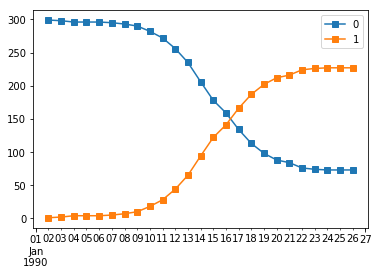

In [11]:
from vivarium.framework.randomness import random
from vivarium.framework.values import modifies_value

class Vaccine:
    def setup(self, builder):
        self.population_view = builder.population_view(['vaccine_protection'])

    @listens_for('initialize_simulants')
    def on_initalize_simulants(self, event):
        s = random('vaccine_protection', event.index)
        s[:] = np.where(s>.8, 1, s)
        self.population_view.update(s)
        
    @modifies_value('infection_prob')
    def modify_infection_prob(self, index, value):
        pop = self.population_view.get(index)
        return value*(1 - pop.vaccine_protection)
    
o = SIObserver()
sim = vtu.setup_simulation([SI3(), Vaccine(), o], population_size=n_simulants, start=t_start)
vtu.pump_simulation(sim, time_step_days=t_timestep, duration=25)
o.show()

In [12]:
df = sim.population.population
df.disease_state.value_counts()

I    227
S     73
Name: disease_state, dtype: int64

In [13]:
g = df.groupby(pd.cut(df.vaccine_protection, bins=4))
t = g.disease_state.value_counts(normalize=True).unstack().fillna(0)
np.round(100*t, 1)

disease_state,I,S
vaccine_protection,,
"(0.00577, 0.255]",100.0,0.0
"(0.255, 0.503]",100.0,0.0
"(0.503, 0.752]",96.3,3.7
"(0.752, 1.0]",18.4,81.6


## TODO: combine this with the boids model!

# Model four: a version that uses the statemachine